## Spell Decoder - Setup and Simulations


In [32]:
from typing import Tuple, List
import numpy as np
from scipy.signal import impulse
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression    
from sklearn.model_selection import cross_validate, KFold
from joblib import Parallel, delayed
from tqdm import tqdm

## Assumptions (simplest case)
Let $C \in \mathbb N$ be the number of `channels` and $T \in \mathbb N$ be the number of sampled `time points` and $\mathcal S$ be the set of `spells`.

We assume that a single trial $X$ has the following properties:
- Weakly stationary stochastic process: $X = (X_t)_{t = 1, \ldots,  T}$ with $X_t \in \mathbb R^{C}$ and $\mathbb E[X_t | s] = a_s$ (regardless of $t$)
- Stable VAR(1) structure: $X_t|s = a_s + \mathbf A_s X_{t-1} + U_t$ with $\,\mathbb E[U_t] = 0, \; \mathbb E[U_tU_t^\top] = \boldsymbol \Sigma, \; \underset{k \neq t}{\forall} \; \mathbb E[U_tU_k^\top] = \mathbf 0$, and all eigenvalues of $A_s$ have modulus less than 1.

<!-- Then there exists a maximum likelihood estimator for $ B_s = (a_s, \mathbf A_s)$ with $\mathbf{Z = (Z_0, \ldots, Z_{T-1})}, \; \mathbf{Z_t = (1, X_t)^\top}$: $\hat B_s = \mathbf{XZ^\top(ZZ^\top)^{-1}}$. -->

### 0. The Data

In [33]:
class Simulator:
    def __init__(self, nSpells:int=3, samplingRate:int=20, nChan:int=102,
                 nObs:int=20, snr:float=.5, pMax:int=5) -> None:
        self.nSpells = nSpells
        self.samplingRate = samplingRate
        self.nChan = nChan
        self.nObs = nObs
        self.snr = snr # signal/noise: maximal amplitude of signal vs noise
        self.pMax = pMax #maximum absolute value of pattern coordinates
        self.varInit = False
        self.dataInit = False
    
    
    def initVAR(self, covarianceFactor:float=0.5, nSecondsIrf:int=5) -> None:
        variance = self.varFromSnr()
        covariance = covarianceFactor * variance
        self.genNoiseCovariance(variance, covariance)
        self.genCoefMat()
        self.genPatterns()
        self.genIRF(nSecondsIrf)
        self.varInit = True
    
    
    def varFromSnr(self) -> float:
        """ calculate variance from SNR: """
        return self.pMax / self.snr
    
    
    # ==== Generators =========================================================
    def genNoiseCovariance(self, var:float, cov:float) -> None:
        variance = var * np.eye(self.nChan)
        covariance = cov * datasets.make_spd_matrix(self.nChan)
        self.sigma = variance + covariance
    
    
    def genCoefMat(self) -> None:
        """ generate coefficient matrix A with eigenvalues in [-1, 1] """
        size = self.nChan, self.nChan
        A = np.random.randint(10, size=size)
        _, eigenvectors = np.linalg.eig(A)
        eigenvalues = np.random.uniform(low=-1., high=1., size=self.nChan)
        pdmat = eigenvectors @ np.diag(eigenvalues) @ np.linalg.inv(eigenvectors)
        self.A = np.real(pdmat)
    
    
    def genPatterns(self) -> None:
        """ generate patterns for each spell """
        self.mus = np.random.randint(self.pMax, size=(self.nSpells, self.nChan))
    
    
    def genIRF(self, nSeconds:int=5, coeffs:list=[1.,2.,2.], plot=False) -> None:
        """ Compute the impulse response on a second order system with a repeated root:
        u(t) = x''(t) + 2*x'(t) + x(t)
        Note: The impulse returns to 0 after roughly nSeconds/2
        """
        nSamples = nSeconds * self.samplingRate
        
        # generate the impulse response
        system = ([1.], coeffs)
        _, irf = impulse(system, N=nSamples)
        
        # normalize it
        max_irf = np.max(irf)
        irf/=max_irf
        self.irf = irf
        
        #optionally plot it
        if plot:
            t = np.linspace(0, nSeconds, nSamples)
            plt.plot(t, irf)
            plt.title("Impulse Response Function", fontsize=12, y=1.02)
            plt.xlabel("Time (s)", fontsize=12)
            plt.ylabel("Amplitude", fontsize=12)
    
    
    def sampleNoise(self, nSamples:int) -> np.ndarray:
        """ generate noise from the covariance matrix """
        return np.random.multivariate_normal(np.zeros(self.nChan), self.sigma, size=nSamples).T
    
    
    def filterVAR(self, x: np.ndarray, nTimesteps:int) -> np.ndarray:
        """ unroll the VAR for nTimesteps by propagating signal and noise with A"""
        noise = self.sampleNoise(nTimesteps)
        x[:,0] += noise[:,0]
        for t in range(1, nTimesteps):
            x[:,t] += self.A @ x[:,t-1] + noise[:,t] 
        return x
    
    
    def genVAR(self, mu: np.ndarray, nSeconds:int=5) -> np.ndarray:
        """ generate a VAR from a pattern """
        assert self.varInit, "VAR not initialized"
        
        nSamples = nSeconds * self.samplingRate
        
        # generate the pattern over time
        mu_irf = np.outer(mu, self.irf)
        
        # pad mu optionally
        tDiffPost = nSamples - mu_irf.shape[1]
        if tDiffPost < 0:
            raise ValueError("IRF longer than trial given nSeconds")
        if tDiffPost > 0:
            padPost = np.zeros((self.nChan, tDiffPost))
            mu_irf = np.concatenate((mu_irf, padPost), axis=1)
                
        # generate the VAR
        x = np.zeros((self.nChan, nSamples))
        x += mu_irf
        x = self.filterVAR(x, nSamples)
        
        return x
    
    
    def genComposedVAR(self, mu1: np.ndarray, mu2: np.ndarray, tIntersect:int=4, tTotal:int=15) -> np.ndarray:
        """ generate a VAR composed of 2 VARs with a given intersection time """
        assert self.varInit, "VAR not initialized"
        
        nSamples = tTotal * self.samplingRate
        
        # generate the 2 patterns over time 
        mu1_irf = np.outer(mu1, self.irf)
        mu2_irf = np.outer(mu2, self.irf)
        
        # pad mu1
        tDiff = nSamples - mu1_irf.shape[1]
        pad = np.zeros((self.nChan, tDiff))
        mu1_irf = np.concatenate((mu1_irf, pad), axis=1)
        
        # pad mu2
        tDiffPre = tIntersect * self.samplingRate
        tDiffPost = nSamples - tDiffPre - mu2_irf.shape[1]
        if tDiffPost < 0:
            minimal_tTotal = mu2_irf.shape[1] / self.samplingRate + tIntersect
            raise ValueError(f"tIntersect + the length of mu2 is longer than tTotal given nSeconds\nshoult be at least {minimal_tTotal}")
        padPre = np.zeros((self.nChan, tDiffPre))
        padPost = np.zeros((self.nChan, tDiffPost))
        mu2_irf = np.concatenate((padPre, mu2_irf, padPost), axis=1)
        
        # generate the VAR
        x = np.zeros((self.nChan, nSamples))
        x += mu1_irf + mu2_irf
        x = self.filterVAR(x, nSamples)
            
        return x


    # ==== Classification =========================================================
    def genDataSet(self, nSecondsTrial:int=5, permute:bool=True) -> None:
        """ generate a training set of VARs with dims (nObs*nSpells, nChan, nSamples)"""
        assert self.varInit, "VAR not initialized"
        
        X = []
        for i in range(self.nSpells):
            mu = self.mus[i]
            X += [self.genVAR(mu, nSecondsTrial) for _ in range(self.nObs)]
        
        X = np.array(X)
        y = np.array(["0"] * self.nObs + ["1"] * self.nObs + ["2"] * self.nObs)
        
        if permute:
            perm = np.random.permutation(len(X))
            X = X[perm]
            y = y[perm]
            
        self.X = X
        self.y = y
        self.dataInit = True

    def kfoldScan(self, model, kf, n_jobs=-1) -> Tuple[np.ndarray, np.ndarray]:
        """ train and test a model on each time point of the VARs, using parallelization"""
        assert self.dataInit, "Data not initialized"
        nSamples = self.X.shape[2]
        datasets = [self.X[:,:,i] for i in range(nSamples)]
        
        def fit_model(x: np.ndarray):
            scores = cross_validate(model, x, self.y, cv=kf, scoring='accuracy', return_train_score=True)
            return scores['train_score'].mean(), scores['test_score'].mean()
        
        results = Parallel(n_jobs=n_jobs)(delayed(fit_model)(dataset) for dataset in tqdm(datasets))
        results = np.array(results)
        return results[:,0], results[:,1]
        
    # ==== Plotting =========================================================
    def plotMat(self, axs, matrix: np.ndarray, title: str, arrange=False) -> None:
        """ plot matrix """
        axs.imshow(matrix, cmap='viridis')
        axs.set_title(title)
        axs.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
        if arrange:
            axs.set_yticks(np.arange(matrix.shape[0]))
            
    def plotSomeChannels(self, x: np.ndarray, nPlots:int, nSeconds:int=5, trialType:str="Single") -> None:
        nSamples = nSeconds * self.samplingRate
        channels = sorted(np.random.choice(self.nChan, size=nPlots, replace=False))
        plt.figure(figsize=(20,10))
        plt.suptitle(f"Simulated {trialType} Trial", fontsize=20)
        t = np.linspace(0, nSeconds, nSamples)

        for i, c in enumerate(channels):
            plt.subplot(5, 1, i+1)
            plt.plot(t, x[c,:])
            plt.title(f"Channel {c}")
            plt.xlabel("Time (s)")
            plt.ylabel("Field (nT)")   
            plt.xlim([0, nSeconds])
            plt.ylim([np.min(x[channels,:]), np.max(x[channels,:])])
            plt.plot(t, np.ones(nSamples) * [0], color='grey', linestyle='--')
            plt.subplots_adjust(hspace=1.)
            
    def plotSomeTrials(self, channel: int, nTrials:int, nSecondsTrial:int) -> None:
        """ plot some trials for a given channel """""
        assert self.dataInit, "Data not initialized"
        
        # prepare data
        nTrialsTotal = self.X.shape[0]
        nSamples = self.X.shape[2]
        trial_indices = sorted(np.random.choice(nTrialsTotal, size=nTrials, replace=False))
        trials_subset = self.X[trial_indices, channel, :]
        yMin, yMax = np.min(trials_subset), np.max(trials_subset)
        
        # plot
        plt.figure(figsize=(20,10))
        t = np.linspace(0, nSecondsTrial, nSamples)
        for i in range(nTrials):
            plt.plot(t, trials_subset[i], alpha=.5)
        plt.xlabel("Time (s)")
        plt.ylabel("Field (nT)")   
        plt.xlim([0, nSecondsTrial])
        plt.ylim(yMin, yMax)
        plt.plot(t, np.ones(nSamples) * [0], color='grey', linestyle='--')
        plt.title(f"{nTrials} Trials on Channel {channel}", fontsize=20, y= 1.02)

    def plotAccuracy(self, plt, train_scores:np.ndarray, test_scores:np.ndarray, nSecondsTrial:float, irfHalfTime:float) -> None:
        nSamples = self.X.shape[2]
        plt.plot(np.linspace(0, nSecondsTrial, nSamples), train_scores)
        plt.plot(np.linspace(0, nSecondsTrial, nSamples), test_scores)
        plt.plot([0, nSecondsTrial], [1/self.nSpells, 1/self.nSpells], color='grey', linestyle='--', linewidth=2)
        plt.axvline(x=irfHalfTime, color='grey', linestyle=':', linewidth=2, alpha=0.5)
        try:
            plt.xlabel("Time (s)")
            plt.ylabel("Mean Accuracy over 10-fold CV")
            plt.title(f"Model Performance for SNR = {self.snr}, n = {self.nObs} per class and {self.nChan} channels")
        except:
            # if plt is axs object
            plt.set_xlabel("Time (s)")
            plt.set_ylabel("Mean Accuracy over 10-fold CV")
            plt.set_title(f"SNR = {self.snr}, n = {self.nObs} per class")
            
        plt.legend(["Training", "Test", "Chance", "IRF Fade-Out"], loc='upper right')
    
sim = Simulator(samplingRate=20, nChan=45, nObs=20, snr=.5)

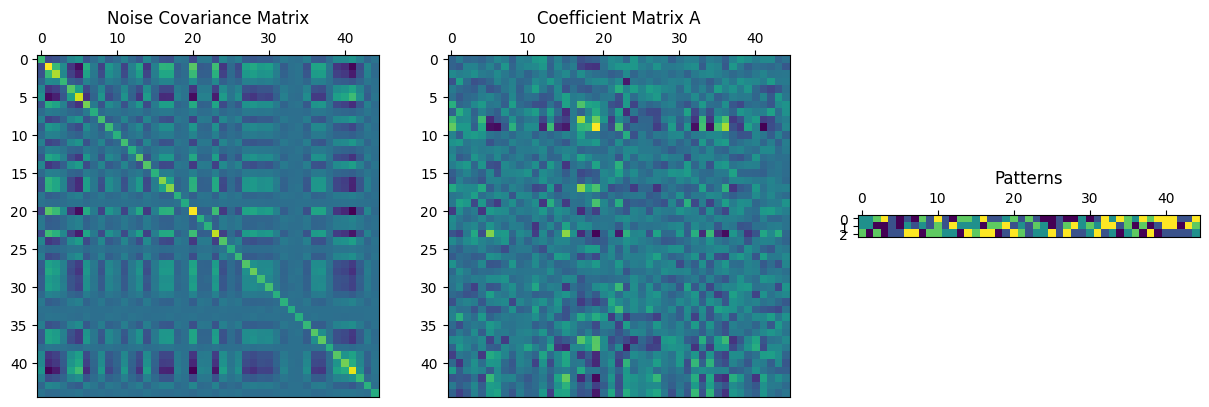

In [34]:
sim.initVAR(covarianceFactor=0.5, nSecondsIrf=5)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sim.plotMat(axs[0], sim.sigma, 'Noise Covariance Matrix')
sim.plotMat(axs[1], sim.A, 'Coefficient Matrix A')
sim.plotMat(axs[2], sim.mus, 'Patterns', arrange=True)

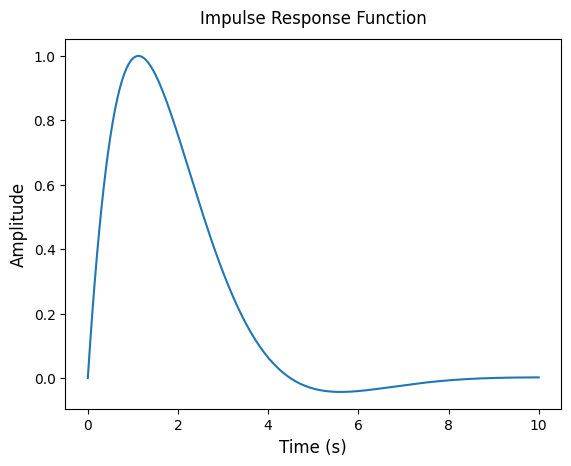

In [35]:
sim.genIRF(nSeconds=10, coeffs=[1.,2.,2.], plot=True) # first five seconds are meaningful

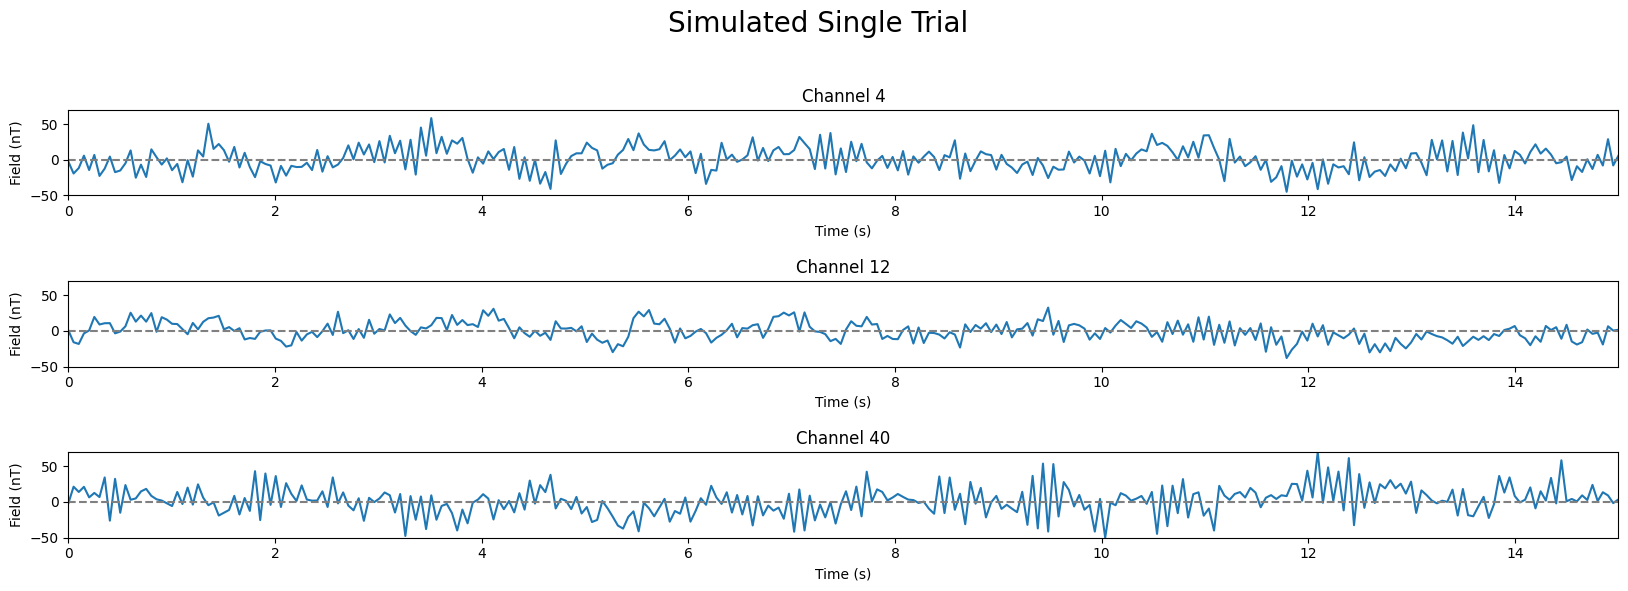

In [36]:
x = sim.genVAR(sim.mus[0], nSeconds=15)
sim.plotSomeChannels(x, nPlots=3, nSeconds=15)

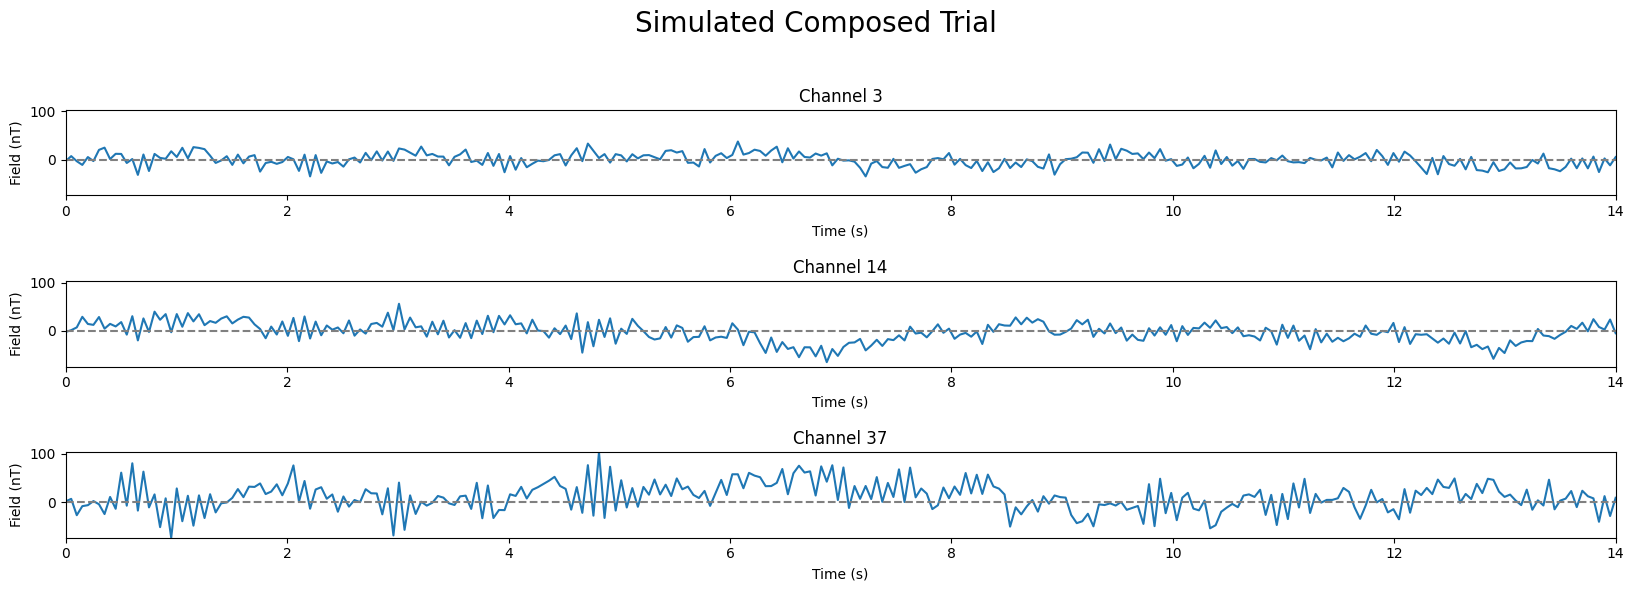

In [37]:
totalTrialDuration = 14
x = sim.genComposedVAR(sim.mus[0], sim.mus[1], tIntersect=4, tTotal=totalTrialDuration)
sim.plotSomeChannels(x, nPlots=3, nSeconds=totalTrialDuration, trialType="Composed")

Let us now generate data and check if we can build a multinomial classifier based on them:

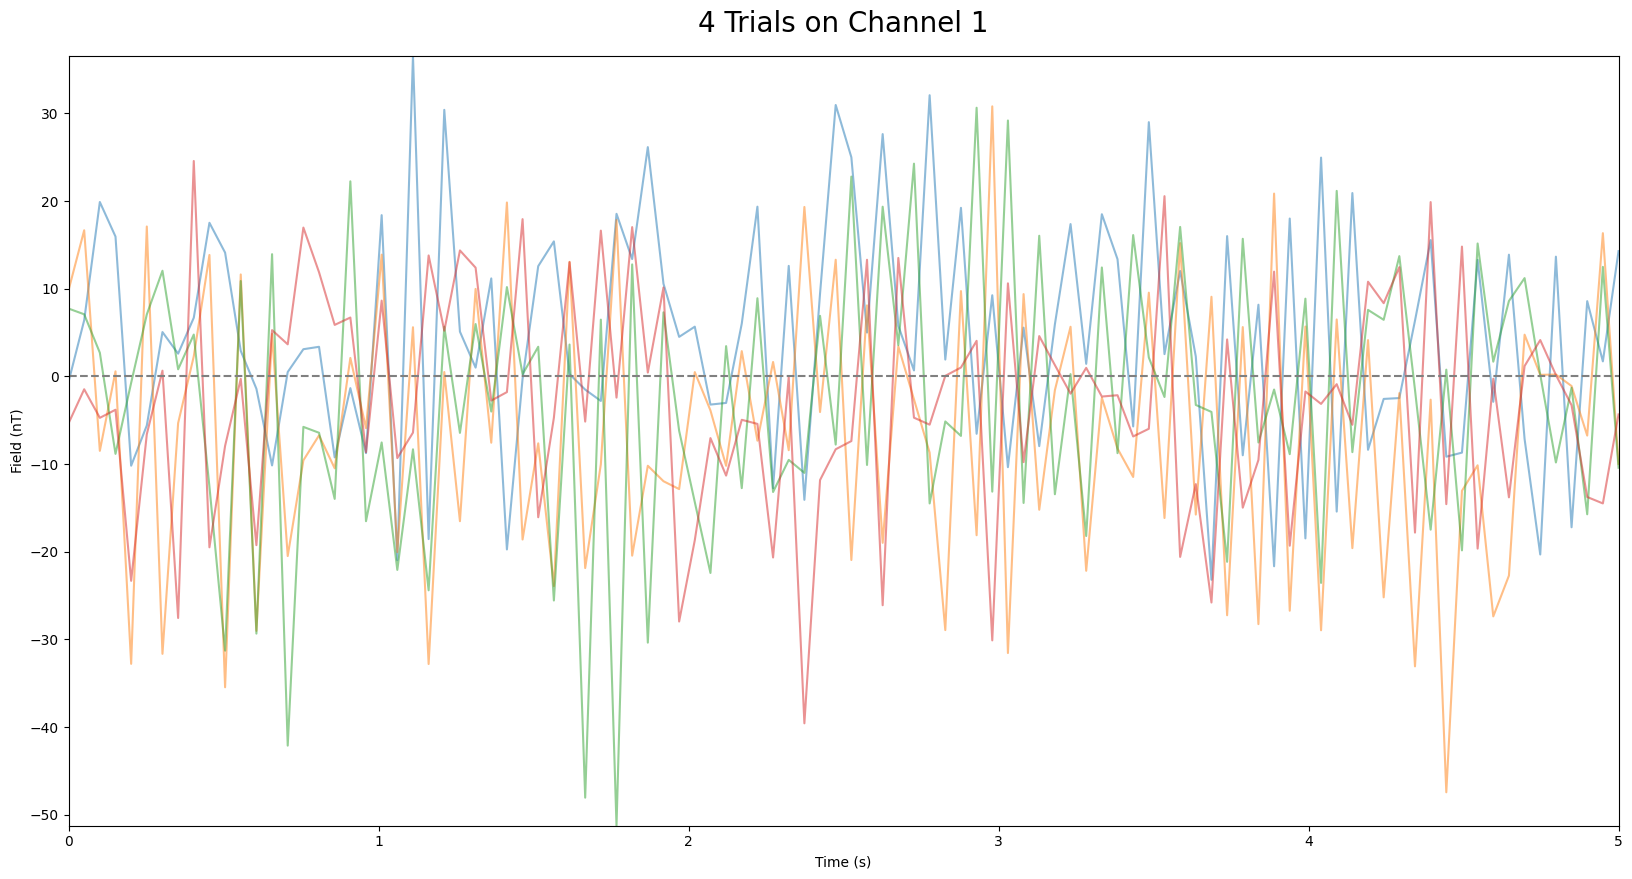

In [38]:
trialDuration = 5
sim.genIRF(nSeconds=trialDuration)
sim.genDataSet(nSecondsTrial=trialDuration)
sim.plotSomeTrials(channel=1, nTrials=4, nSecondsTrial=trialDuration)


In [39]:
mnc = LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty='l2')
kf = KFold(n_splits=10, shuffle=False)
train_scores, test_scores = sim.kfoldScan(mnc, kf)


100%|██████████| 100/100 [00:03<00:00, 25.98it/s]


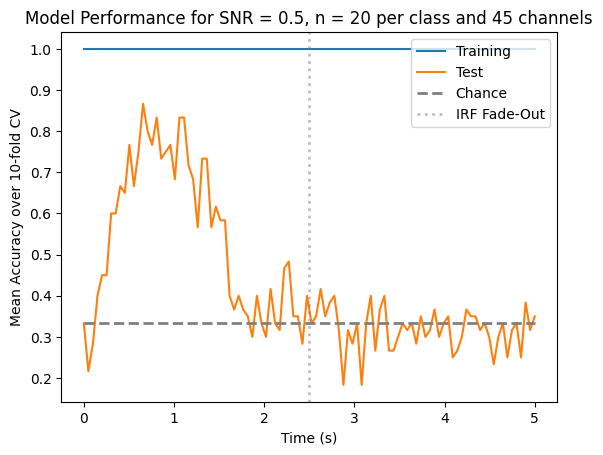

In [40]:
sim.plotAccuracy(plt, train_scores, test_scores, nSecondsTrial=trialDuration, irfHalfTime=trialDuration/2)

Wrapping it up in one function:

In [41]:
def testDecoder(sim: Simulator, mnc: LogisticRegression, kf: KFold, plt, nObs: int = 20, snr: float = .5, covarianceFactor: float = 0.5,
                nSecondsTrial: int = 5, nSecondsIrf: int = 5):
    sim.nObs = nObs
    sim.snr = snr

    # generate noise covariance
    variance = sim.varFromSnr()
    covariance = covarianceFactor * variance
    sim.genNoiseCovariance(variance, covariance)

    # generate IRF
    sim.genIRF(nSecondsIrf)
    sim.varInit = True

    # generate data
    sim.genDataSet(nSecondsTrial)

    # fit model
    train_scores, test_scores = sim.kfoldScan(clone(mnc), kf)
    sim.plotAccuracy(plt, train_scores, test_scores,
                     nSecondsTrial, nSecondsIrf/2)


def gridSearchWrapper(mnc: LogisticRegression, kf: KFold, nObsList: List[int], snrList: List[float], nSecondsTrial: int = 5, nSecondsIrf: int = 5):
    assert nSecondsTrial >= nSecondsIrf, "IRF must be shorter than trial duration"
    sim = Simulator()
    sim.genPatterns()
    sim.genCoefMat()

    # generate subplots in a grid of size len(nObsList) x len(snrList)
    nRows = len(nObsList)
    nCols = len(snrList)
    fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=(5*nCols, 5*nRows))
    fig.subplots_adjust(hspace=.2, wspace=.2)

    for i, nObs in enumerate(nObsList):
        for j, snr in enumerate(snrList):
            print(f"Testing for SNR = {snr} and nObs = {nObs}")
            testDecoder(sim, mnc, kf, axs[i, j],
                        nObs=nObs, snr=snr, nSecondsTrial=nSecondsTrial, nSecondsIrf=nSecondsIrf)

Testing for SNR = 0.01 and nObs = 20
Testing for SNR = 0.1 and nObs = 20
Testing for SNR = 0.01 and nObs = 30
Testing for SNR = 0.1 and nObs = 30
Testing for SNR = 0.01 and nObs = 40
Testing for SNR = 0.1 and nObs = 40


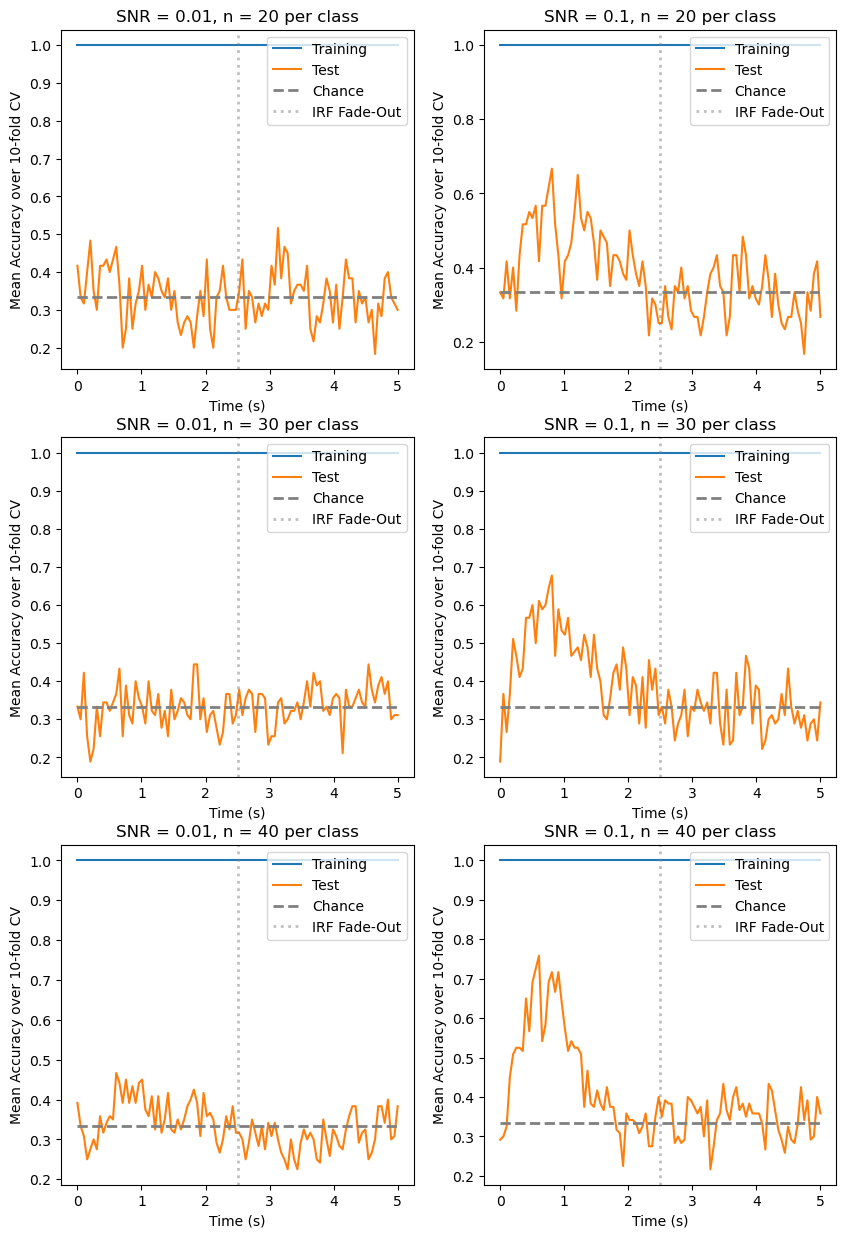

In [42]:
nObsList = [20, 25, 30]
snrList=[0.01, 0.05, 0.1]
gridSearchWrapper(mnc, kf, nObsList, snrList)

Additional ideas:

- normalize and scale spd matrix for covmat
- variation in starting point
- true pattern similarity
- proportion of non-zero channels for true pattern (how channel-specific is the pattern?)
- regularization, boosting
- Bayesian classifier (one set of parameters, updated by scanning throughout)  